In [1]:
import pandas as pd
import numpy as np
import statsmodels.formula.api as smf
import datetime as dt
import matplotlib.pyplot as plt
import seaborn as sns

from factor_analyzer import FactorAnalyzer, ConfirmatoryFactorAnalyzer, ModelSpecificationParser

from collections import defaultdict

In [2]:
# Load data, drop test entry
df = pd.read_csv("ads.csv", on_bad_lines="skip", delimiter=",")
df = df[df["Finished"] == "True"] #.drop(2)
df = df[(df["PROLIFIC_PID"] != "XXXXXPID") & (df["Finished"] == "True")]
print(f"Total responses valid: {len(df)}")
df.head()

Total responses valid: 197


,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,111110v111111_3,Q359_First Click,Q359_Last Click,Q359_Page Submit,Q359_Click Count,Q2_First Click.3,Q2_Last Click.3,Q2_Page Submit.3,Q2_Click Count.3,PROLIFIC_PID
5,2025-06-13 15:04:44,2025-06-13 15:08:37,IP Address,NaN,100,233,True,2025-06-13 15:08:37,R_8GxfXEQXq24VXoq,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6135ce2a32b53777552a46b0
6,2025-06-13 15:04:08,2025-06-13 15:12:34,IP Address,NaN,100,506,True,2025-06-13 15:12:34,R_3g0wSbUefCEOVXX,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,3.436,0,68435d50e3c682b144a0b87a
7,2025-06-13 15:03:47,2025-06-13 15:14:58,IP Address,NaN,100,670,True,2025-06-13 15:14:58,R_8CcPqZNDeXqQmHw,NaN,...,NaN,NaN,NaN,NaN,NaN,1.892,1.892,2.335,1,60f06a479c4f3ec0a536d40a
8,2025-06-13 15:04:54,2025-06-13 15:15:30,IP Address,NaN,100,636,True,2025-06-13 15:15:31,R_8pncQr6UwLawYAP,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,5.623,0,5e8126a0d32cbc817a4df7b6
9,2025-06-13 15:04:35,2025-06-13 15:16:18,IP Address,NaN,100,703,True,2025-06-13 15:16:18,R_24PpEyytoYIQwAG,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,12.153,0,605e1fc0be766e80d0104df3


In [4]:
df2 = pd.read_csv("jobs.csv", on_bad_lines="skip", delimiter=";")
df2 = df2[(df2["PROLIFIC_PID"] != "XXXXXPID") & (df2["Finished"] == "TRUE")]
print(f"Total responses valid: {len(df2)}")
df2.head()

Total responses valid: 196


,StartDate,EndDate,Status,IPAddress,Progress,Duration (in seconds),Finished,RecordedDate,ResponseId,RecipientLastName,...,111110v111111_3,Q361_First Click,Q361_Last Click,Q361_Page Submit,Q361_Click Count,Q364_First Click,Q364_Last Click,Q364_Page Submit,Q364_Click Count,PROLIFIC_PID
2,21-12-2024 15:46,21-12-2024 16:02,IP Address,NaN,100,1014,TRUE,21-12-2024 16:02,R_8THR16bEjvYNFzz,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0
3,22-12-2024 17:35,22-12-2024 17:48,IP Address,NaN,100,772,TRUE,22-12-2024 17:48,R_8xyWYB0rOpyjRuh,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,13.837,0,1
4,22-12-2024 20:09,22-12-2024 20:26,IP Address,NaN,100,990,TRUE,22-12-2024 20:26,R_2il5McbOGb6rpVr,NaN,...,NaN,NaN,NaN,NaN,NaN,2.349,4.309,4.869,2,2
5,21-12-2024 16:20,22-12-2024 21:53,IP Address,NaN,100,106370,TRUE,22-12-2024 21:53,R_22VcLcH0ym5Ms3q,NaN,...,NaN,NaN,NaN,NaN,NaN,4.261,4.261,4.816,1,3
6,23-12-2024 16:54,23-12-2024 17:03,IP Address,NaN,100,536,TRUE,23-12-2024 17:03,R_1X0xxCGkUFlxJvb,NaN,...,NaN,NaN,NaN,NaN,NaN,0,0,6.23,0,6763fe3ad8eeb4e6d8ce1328


In [5]:
# Just the cognitive orientation questions per participant
df_co = df[["PROLIFIC_PID", "Q1.1", "Q2.1", "Q3.1", "Q4.1", "Q5", "Q6",
            "Q7", "Q8", "Q9", "Q10", "Q11", "Q12", 
            "Q13", "Q14", "Q15", "Q16", "Q17", "Q18", 
            "Q19", "Q20", "Q21", "Q22", "Q23", "Q24", 
            "Q25"]].T

# Drop columns by testers
# df_co = df_co.rename(columns = {0 : "Question text"})

# # Set column names to prolific IDs 
df_co.columns = df_co.iloc[0].values.tolist()
df_co = df_co.drop(index = "PROLIFIC_PID")

# Rescale
df_co = df_co.replace({"Strongly disagree" : 0, "Somewhat disagree" : 1,
                       "Neither agree nor disagree" : 2, "Somewhat agree" : 3,
                       "Strongly agree" : 4}).iloc[:, 4:]

df_co.head()

C:\Users\roans\AppData\Local\Temp\ipykernel_20444\3489471624.py:16: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_co = df_co.replace({"Strongly disagree" : 0, "Somewhat disagree" : 1,


,605e1fc0be766e80d0104df3,66656db67864801db6a0e2c6,61241440b58a4621e8c2f050,5fe230ee29598a57972db630,66073c4673a44d32dc246496,6845230f58a84bd958387c70,677ced2e1a038fd5c8c3df1f,683f9cd0caffa2a9c37df1a1,669a9bee096a778e4939c25c,672541915a9a5ac8b878a28e,...,66735fc590d2b006289002b6,67f09ad02524e8b1d810e0a4,608c3c5e1cf6e05149f36b6a,67a507f52decb8dbaacc29e3,6612990fa0e1d2605331a833,6849c804c412a1bdd6d48f56,612058b64e8bd208d39fbe68,67adeb124ea5587ac8afa3ac,6755a0ba328d7effd6e56a20,67eac4d6bf3d1c4df7bd65df
Q1.1,1,1,0,1,2,3,0,1,0,1,...,0,0,1,0,1,1,1,1,0,1
Q2.1,2,4,4,2,3,3,4,4,3,3,...,3,4,2,4,3,2,3,4,4,2
Q3.1,2,0,3,3,3,1,1,1,1,1,...,3,0,1,3,1,1,4,2,2,1
Q4.1,3,1,0,1,3,3,0,0,2,1,...,1,0,1,0,3,3,2,1,2,1
Q5,1,4,4,4,3,2,4,3,3,3,...,2,3,2,4,1,2,3,3,3,3


In [6]:
# Just the cognitive orientation questions per participant
df_co2 = df2[["PROLIFIC_PID", "Q1.1", "Q2 ", "Q3.1", "Q4.1", "Q5", "Q6",
            "Q7", "Q8", "Q9", "Q10", "Q11", "Q12", 
            "Q13", "Q14", "Q15", "Q16", "Q17", "Q18", 
            "Q19", "Q28", "Q29", "Q30", "Q31", "Q32", 
            "Q33"]].T

# Drop columns by testers
df_co2 = df_co2.rename(columns = {0 : "Question text"}, index={"Q2 ": "Q2.1",
                                                               "Q28": "Q20",
                                                               "Q29": "Q21",
                                                               "Q30": "Q22",
                                                               "Q31": "Q23",
                                                               "Q32": "Q24",
                                                               "Q33": "Q25"})

# Set column names to prolific IDs
df_co2 = df_co2.drop(index = "PROLIFIC_PID")

# Rescale
df_co2 = df_co2.replace({"Strongly disagree" : 0, "Somewhat disagree" : 1,
                         "Neither agree nor disagree" : 2, "Somewhat agree" : 3,
                         "Strongly agree" : 4})

df_co2.head()

C:\Users\roans\AppData\Local\Temp\ipykernel_20444\784585808.py:21: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df_co2 = df_co2.replace({"Strongly disagree" : 0, "Somewhat disagree" : 1,


,2,3,4,5,6,7,8,9,10,11,...,192,193,194,195,196,197,198,199,202,203
Q1.1,0,2,1,1,1,0,1,0,1,2,...,1,1,0,1,1,3,0,1,1,1
Q2.1,4,3,3,2,3,4,3,4,2,3,...,1,3,4,4,3,3,2,4,3,3
Q3.1,1,1,1,1,1,0,3,1,1,2,...,1,1,0,1,3,1,0,1,3,1
Q4.1,0,1,1,1,1,0,0,1,0,1,...,0,1,0,1,3,1,0,1,1,2
Q5,4,1,2,3,3,4,2,3,2,2,...,2,2,1,3,3,2,3,3,3,1


In [7]:
df_co = pd.merge(left=df_co, right=df_co2, left_index=True, right_index=True)
df_co.head()

,605e1fc0be766e80d0104df3,66656db67864801db6a0e2c6,61241440b58a4621e8c2f050,5fe230ee29598a57972db630,66073c4673a44d32dc246496,6845230f58a84bd958387c70,677ced2e1a038fd5c8c3df1f,683f9cd0caffa2a9c37df1a1,669a9bee096a778e4939c25c,672541915a9a5ac8b878a28e,...,192,193,194,195,196,197,198,199,202,203
Q1.1,1,1,0,1,2,3,0,1,0,1,...,1,1,0,1,1,3,0,1,1,1
Q2.1,2,4,4,2,3,3,4,4,3,3,...,1,3,4,4,3,3,2,4,3,3
Q3.1,2,0,3,3,3,1,1,1,1,1,...,1,1,0,1,3,1,0,1,3,1
Q4.1,3,1,0,1,3,3,0,0,2,1,...,0,1,0,1,3,1,0,1,1,2
Q5,1,4,4,4,3,2,4,3,3,3,...,2,2,1,3,3,2,3,3,3,1


In [8]:
co_groups = {"Need for Cognition" : {
               "Q1.1" : {"Reverse" : True},
               "Q2.1"  : {"Reverse" : False},
               "Q3.1" : {"Reverse" : True},
               "Q4.1" : {"Reverse" : True},
               "Q5"   : {"Reverse" : False}
               },
            "Need for closure" : {
               "Q6"  : {"Reverse" : False},
               "Q7"  : {"Reverse" : True},
               "Q8"  : {"Reverse" : False},
               "Q9"  : {"Reverse" : False}, 
               "Q10" : {"Reverse" : False},
               "Q11" : {"Reverse" : False},
               "Q12" : {"Reverse" : False}
            },
            "Susceptibility to persuasion" : {
                "Q13" : {"Reverse" : False},
                "Q14" : {"Reverse" : False},
                "Q15" : {"Reverse" : False},
                "Q16" : {"Reverse" : False}
            },
            "Skepticism" : {
                "Q17" : {"Reverse" : False},
                "Q18" : {"Reverse" : True},
                "Q19" : {"Reverse" : False},
                "Q20" : {"Reverse" : False},
                "Q21" : {"Reverse" : False}
            },
            "AI Expertise" : {
                "Q22" : {"Reverse" : False},
                "Q23" : {"Reverse" : False},
                "Q24" : {"Reverse" : False},
                "Q25" : {"Reverse" : True}
            }
        }

sub_dfs = {}

for group, questions in co_groups.items():
    temp = df_co.loc[list(questions.keys())]
    
    for question, reverse in questions.items():
        if reverse["Reverse"]:    
            temp.loc[question] = temp.loc[question].replace({4:0, 3:1, 1:3, 0:4})
            
#     temp = temp.drop(columns = "Question text")
    
    sub_dfs[group] = temp
    
sub_dfs["Need for Cognition"]

,605e1fc0be766e80d0104df3,66656db67864801db6a0e2c6,61241440b58a4621e8c2f050,5fe230ee29598a57972db630,66073c4673a44d32dc246496,6845230f58a84bd958387c70,677ced2e1a038fd5c8c3df1f,683f9cd0caffa2a9c37df1a1,669a9bee096a778e4939c25c,672541915a9a5ac8b878a28e,...,192,193,194,195,196,197,198,199,202,203
Q1.1,3,3,4,3,2,1,4,3,4,3,...,3,3,4,3,3,1,4,3,3,3
Q2.1,2,4,4,2,3,3,4,4,3,3,...,1,3,4,4,3,3,2,4,3,3
Q3.1,2,4,1,1,1,3,3,3,3,3,...,3,3,4,3,1,3,4,3,1,3
Q4.1,1,3,4,3,1,1,4,4,2,3,...,4,3,4,3,1,3,4,3,3,2
Q5,1,4,4,4,3,2,4,3,3,3,...,2,2,1,3,3,2,3,3,3,1


In [9]:
all_scaled = pd.concat(list(sub_dfs.values()))

# Drop incomplete responses
all_scaled = all_scaled.drop(columns=all_scaled.columns[all_scaled.isna().sum() > 0]).T

In [10]:
# The questions per factor
model_dict = {k : list(v.keys()) for k, v in co_groups.items()}

# Run CFA
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(all_scaled, model_dict)
cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=False) 
cfa.fit(all_scaled.values) 
cfa.loadings_ 

array([[ 0.76044717,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.25125196,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.50569506,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.69331602,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.21405613,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.14592837,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.19048372,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.34106919,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.03327847,  0.        ,  0.        ,  0.        ],
       [ 0.        , -0.06783707,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.52156399,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.02904242,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.32661374,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.7

In [11]:
# Drop scores below the threshold (.1)
scores = cfa.loadings_
scores = np.array(scores).flatten()
scores = scores[scores != 0]

co_groups_updated = defaultdict(dict)

counter = 0

to_drop = []

for group, questions in co_groups.items():
    for question in questions:
        # Q25 is 'objective' and should therefore be included regardless of self-report alignment
        if scores[counter] > .1 or question == "Q25":
            
            co_groups_updated[group][question] = co_groups[group][question]
        
        else:
            print(f"Dropping: {question}")
            to_drop.append(question)

        counter += 1
        
co_groups = co_groups_updated
all_scaled_corrected = all_scaled.drop(columns=to_drop)

### Rerun CFA with updated questions list
# The questions per factor
model_dict = {k : list(v.keys()) for k, v in co_groups_updated.items()}

# Run CFA
model_spec = ModelSpecificationParser.parse_model_specification_from_dict(all_scaled_corrected,
                                                                          model_dict)
cfa = ConfirmatoryFactorAnalyzer(model_spec, disp=False) 
cfa.fit(all_scaled_corrected.values) 
cfa.loadings_

Dropping: Q9
Dropping: Q10
Dropping: Q12
Dropping: Q18


array([[ 0.75970827,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.25158502,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.50653599,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.69268315,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.21579378,  0.        ,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.14396054,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.19146524,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.34222807,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.51551223,  0.        ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.32318386,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.7678339 ,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.18786363,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0.14217069,  0.        ,  0.        ],
       [ 0.        ,  0.        ,  0. 

In [12]:
# Calculate average scores for each concept
concept_scores = pd.DataFrame()

for concept, questions in co_groups.items():
    concept_scores[concept] = all_scaled[list(questions.keys())].sum(axis=1) / (len(questions.keys()) * 4)

# Output results
concept_scores.describe()

,Need for Cognition,Need for closure,Susceptibility to persuasion,Skepticism,AI Expertise
count,388.000000,388.000000,388.000000,388.000000,388.000000
mean,0.685180,0.595522,0.675097,0.772552,0.658666
std,0.158581,0.144292,0.153873,0.137808,0.150514
min,0.200000,0.187500,0.000000,0.375000,0.187500
25%,0.550000,0.500000,0.562500,0.687500,0.562500
50%,0.700000,0.625000,0.687500,0.750000,0.687500
75%,0.800000,0.687500,0.750000,0.875000,0.750000
max,1.000000,1.000000,1.000000,1.000000,1.000000


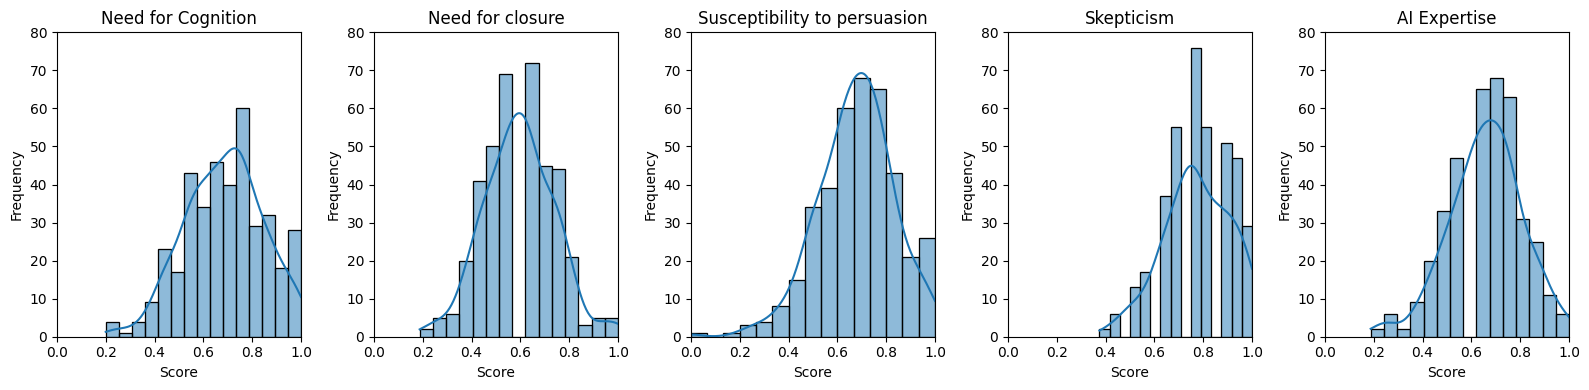

In [20]:
# Function to plot the distributions
def plot_concept_score_distributions(dataframe):
    num_columns = len(dataframe.columns)
    num_rows = 1 # (num_columns + 2) // 3  # Arrange in rows of 3 plots

    fig, axes = plt.subplots(num_rows, 5, figsize=(16, num_rows * 4))
    axes = axes.flatten()

    for i, column in enumerate(dataframe.columns):
        sns.histplot(dataframe[column], kde=True, ax=axes[i], bins=15)
        axes[i].set_title(column)
        axes[i].set_xlabel("Score")
        axes[i].set_xlim(0, 1)
        axes[i].set_ylim(0, 80)
        axes[i].set_ylabel("Frequency")

    # Turn off unused axes
    for j in range(i + 1, len(axes)):
        axes[j].axis("off")

    plt.tight_layout()
    plt.savefig('co_dists.pdf')
    plt.show()

# Example usage
plot_concept_score_distributions(concept_scores)


In [14]:
concept_scores.to_csv("../results/cognitive_orientations.csv")